## 1️⃣ Importar Librerías y Configuración

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import special, integrate, signal, fft
import sys, os
from typing import Dict, Tuple, List, Optional, Callable
import warnings
warnings.filterwarnings('ignore')

# Agregar path al proyecto
sys.path.insert(0, os.path.abspath('../python'))

print("✓ Librerías base importadas")
print(f"  NumPy: {np.__version__}")
print(f"  SciPy: {fft.__name__}")

✓ Librerías base importadas
  NumPy: 2.2.6
  SciPy: scipy.fft


## 2️⃣ Definición de Tipos de Condiciones de Frontera

### Clasificación Matemática:
- **Dirichlet**: Valor especificado en frontera (u = g)
- **Neumann**: Gradiente normal especificado (∂u/∂n = h)
- **Mixta/Robin**: Combinación de Dirichlet y Neumann
- **Periódica**: Continuidad cíclica
- **No-deslizamiento (No-slip)**: u = 0 en pared (Dirichlet especial)
- **Deslizamiento libre (Free-slip)**: u·n = 0, τ·u = 0

In [2]:
class BoundaryCondition:
    """Clase base para condiciones de frontera en Navier-Stokes"""
    
    def __init__(self, name: str, bc_type: str, location: str):
        """
        Parámetros:
        -----------
        name : str
            Identificador de la frontera
        bc_type : str
            Tipo: 'dirichlet', 'neumann', 'mixed', 'periodic', 'noslip', 'freeslip'
        location : str
            Ubicación física: 'inlet', 'outlet', 'wall', 'interface'
        """
        self.name = name
        self.bc_type = bc_type
        self.location = location
        
    def apply(self, field: np.ndarray, time: float = 0.0) -> np.ndarray:
        """Aplicar la condición de frontera"""
        raise NotImplementedError

class DirichletBC(BoundaryCondition):
    """Condición de Dirichlet: valor especificado u = g(x, t)"""
    
    def __init__(self, name: str, location: str, value_func: Callable):
        super().__init__(name, 'dirichlet', location)
        self.value_func = value_func
        self.description = f"Dirichlet BC en {location}: u = g(x,t)"
        
    def apply(self, field: np.ndarray, time: float = 0.0) -> np.ndarray:
        """Aplicar Dirichlet BC"""
        return self.value_func(time)

class NeumannBC(BoundaryCondition):
    """Condición de Neumann: gradiente normal ∂u/∂n = h(x, t)"""
    
    def __init__(self, name: str, location: str, gradient_func: Callable):
        super().__init__(name, 'neumann', location)
        self.gradient_func = gradient_func
        self.description = f"Neumann BC en {location}: ∂u/∂n = h(x,t)"
        
    def apply(self, field: np.ndarray, time: float = 0.0) -> np.ndarray:
        """Aplicar Neumann BC mediante aproximación de diferencias finitas"""
        return self.gradient_func(time)

class NoSlipBC(BoundaryCondition):
    """Condición de no-deslizamiento: u = 0 en pared"""
    
    def __init__(self, name: str = "wall"):
        super().__init__(name, 'noslip', 'wall')
        self.description = "No-slip BC: u = 0 (pared sólida)"
        
    def apply(self, field: np.ndarray, time: float = 0.0) -> np.ndarray:
        return np.zeros_like(field)

class FreeSlipBC(BoundaryCondition):
    """Condición de deslizamiento libre: u·n = 0, τ·u = 0"""
    
    def __init__(self, name: str = "freeslip"):
        super().__init__(name, 'freeslip', 'interface')
        self.description = "Free-slip BC: u·n = 0, τ·u = 0 (interfaz sin fricción)"
        
    def apply(self, field: np.ndarray, time: float = 0.0, normal: np.ndarray = None) -> np.ndarray:
        if normal is None:
            normal = np.array([0, 0, 1])  # Normal default
        # Proyectar campo tangencial
        tangential = field - np.dot(field, normal) * normal
        return tangential

print("✓ Clases de condiciones de frontera definidas")

✓ Clases de condiciones de frontera definidas


## 3️⃣ Configuraciones Físicas Comunes

### A. Flujo en Cavidad (Lid-driven cavity)
- Paredes: no-slip (u = 0)
- Tapa móvil: u = (U₀, 0, 0)
- Puntos críticos: esquinas donde se concentra vorticidad

In [4]:
class LidDrivenCavity:
    """Configuración física: Cavidad con tapa móvil"""
    
    def __init__(self, lid_velocity: float = 1.0, reynolds: float = 1000):
        self.U0 = lid_velocity  # Velocidad de la tapa
        self.Re = reynolds
        self.nu = 1.0 / reynolds  # Viscosidad cinemática
        self.boundary_conditions = {}
        self._setup_bcs()
        
    def _setup_bcs(self):
        """Configurar condiciones de frontera para cavidad"""
        # Paredes: no-slip
        self.boundary_conditions['bottom'] = NoSlipBC('bottom')
        self.boundary_conditions['left'] = NoSlipBC('left')
        self.boundary_conditions['right'] = NoSlipBC('right')
        
        # Tapa móvil: Dirichlet con velocidad U0
        self.boundary_conditions['top'] = DirichletBC(
            'top',
            'wall',
            lambda t: np.array([self.U0, 0.0, 0.0])
        )
        
    def get_critical_points(self) -> Dict[str, Tuple[float, float]]:
        """Puntos críticos donde se concentra vorticidad"""
        return {
            'corner_bottom_left': (0.0, 0.0),
            'corner_bottom_right': (1.0, 0.0),
            'corner_top_left': (0.0, 1.0),
            'corner_top_right': (1.0, 1.0),
            'vortex_center': (0.5, 0.5)  # Centro aproximado del vórtice principal
        }
    
    def analyze_force_interactions(self) -> Dict:
        """Analizar interacción de fuerzas en puntos críticos"""
        return {
            'pressure_gradient': 'Acelera fluido desde pared a tapa',
            'viscous_stress': 'Disipa energía en capa límite (espesor ~ Re^-0.25)',
            'advection': 'Transporta vorticidad desde tapa hacia esquinas',
            'corner_eddies': 'Micro-vórtices en esquinas (Re dependiente)'
        }

print("✓ Configuración Lid-Driven Cavity implementada")

✓ Configuración Lid-Driven Cavity implementada


### B. Flujo en Canal (Channel flow)
- Entrada: perfil Poiseuille
- Paredes: no-slip
- Salida: Neumann (traction-free)

In [5]:
class ChannelFlow:
    """Configuración física: Flujo en canal"""
    
    def __init__(self, u_max: float = 1.0, reynolds: float = 1000, L: float = 2*np.pi):
        self.u_max = u_max  # Velocidad máxima (en eje)
        self.Re = reynolds
        self.nu = 1.0 / reynolds
        self.L = L  # Longitud del canal
        self.boundary_conditions = {}
        self._setup_bcs()
        
    def poiseuille_profile(self, y: np.ndarray) -> np.ndarray:
        """Perfil de velocidad parabólico de Poiseuille: u(y) = U_max * (1 - y²)"""
        return self.u_max * (1.0 - y**2)
    
    def _setup_bcs(self):
        """Configurar condiciones de frontera para canal"""
        # Entrada: Dirichlet con perfil Poiseuille
        self.boundary_conditions['inlet'] = DirichletBC(
            'inlet',
            'inlet',
            lambda t: self.u_max  # Velocidad característica
        )
        
        # Salida: Neumann (traction-free)
        self.boundary_conditions['outlet'] = NeumannBC(
            'outlet',
            'outlet',
            lambda t: 0.0  # ∂u/∂x = 0
        )
        
        # Paredes: no-slip
        self.boundary_conditions['wall_top'] = NoSlipBC('wall_top')
        self.boundary_conditions['wall_bottom'] = NoSlipBC('wall_bottom')
        
    def analyze_force_interactions(self) -> Dict:
        """Analizar interacción de fuerzas"""
        return {
            'pressure_gradient': 'Impulsa flujo (constante en canal)',
            'viscous_stress': 'Se opone al gradiente de presión',
            'capa_limite': f'Espesor: δ ~ √(ν*L/U) ~ {np.sqrt(self.nu*self.L/self.u_max):.4f}',
            'balance': 'En flujo desarrollado: ∇p + ∇²u = ∂u/∂t'
        }

print("✓ Configuración Channel Flow implementada")

✓ Configuración Channel Flow implementada


### C. Capa Límite Turbulenta (Turbulent Boundary Layer)
- Pared: no-slip
- Flujo libre: Dirichlet con U = U∞
- Interacción de vorticidad con pared

In [6]:
class TurbulentBoundaryLayer:
    """Configuración física: Capa límite turbulenta sobre placa plana"""
    
    def __init__(self, u_infinity: float = 1.0, reynolds: float = 10000, thickness_0: float = 0.01):
        self.U_inf = u_infinity
        self.Re = reynolds
        self.nu = 1.0 / reynolds
        self.delta_0 = thickness_0  # Espesor inicial de capa límite
        self.boundary_conditions = {}
        self._setup_bcs()
        
    def blasius_profile(self, eta: np.ndarray) -> np.ndarray:
        """Aproximación de perfil de Blasius: u/U∞ ≈ f'(η) donde η = y/δ"""
        # Aproximación analítica simplificada
        return self.U_inf * (1.0 - np.exp(-2.0 * eta))
    
    def _setup_bcs(self):
        """Configurar condiciones de frontera"""
        # Pared: no-slip
        self.boundary_conditions['wall'] = NoSlipBC('wall')
        
        # Flujo libre: Dirichlet
        self.boundary_conditions['freestream'] = DirichletBC(
            'freestream',
            'interface',
            lambda t: self.U_inf
        )
    
    def analyze_force_interactions(self) -> Dict:
        """Análisis de fuerzas en capa límite turbulenta"""
        tau_wall_estimate = 0.5 * self.Re**(-0.25)  # Esfuerzo cortante en pared
        return {
            'viscous_stress_wall': f'τ_wall ~ {tau_wall_estimate:.6f} (adhiere fluido a pared)',
            'pressure_gradient': 'Típicamente ≈ 0 (flujo auto-similar)',
            'produccion_vorticidad': 'Máxima en pared: ω ~ τ/μ',
            'difusion_vorticidad': 'Se difunde hacia flujo libre',
            'espesor_capa_limite': f'δ(x) ~ x/√Re (crece con distancia)',
            'espesor_turbulencia': f'δ_t ~ 0.2δ para Re >> 1'
        }

print("✓ Configuración Turbulent Boundary Layer implementada")

✓ Configuración Turbulent Boundary Layer implementada


## 4️⃣ Análisis de Puntos Críticos de Interacción de Fuerzas

In [8]:
class CriticalPointAnalyzer:
    """Analizador de puntos críticos donde interactúan fuerzas físicas"""
    
    def __init__(self):
        self.critical_points = {}
    
    def analyze_cavity(self, cavity: LidDrivenCavity) -> Dict:
        """Analizar puntos críticos en cavidad con tapa móvil"""
        analysis = {}
        
        analysis['esquinas'] = {
            'descripcion': 'Concentración de vorticidad',
            'fuerzas_dominantes': ['Viscosidad (alta curvatura)', 'Gradiente de presión'],
            'efecto_reynolds': 'Vórtices secundarios más fuertes con Re creciente',
            'escala_longitud': f'δ ~ Re^(-0.25) ~ {cavity.Re**(-0.25):.4f}'
        }
        
        analysis['centro_vortice'] = {
            'descripcion': 'Vórtice principal',
            'fuerzas_dominantes': ['Advección (u·∇)u', 'Difusión viscosa'],
            'balance': 'Cuasi-equilibrio entre advección y difusión',
            'oscilaciones': 'Pueden existir oscilaciones periódicas/caóticas'
        }
        
        analysis['capa_limite_pared'] = {
            'descripcion': 'Región cercana a paredes',
            'fuerzas_dominantes': ['Esfuerzo cortante viscoso', 'Presión'],
            'gradiente_velocidad': f'∂u/∂n ~ U0/(δ) ~ U0*Re^0.25',
            'disipacion': 'Máxima en capa límite'
        }
        
        return analysis
    
    def analyze_channel(self, channel: ChannelFlow) -> Dict:
        """Analizar puntos críticos en canal"""
        analysis = {}
        
        analysis['entrada'] = {
            'descripcion': 'Desarrollo del perfil',
            'fuerzas': 'Gradiente de presión × Viscosidad',
            'longitud_desarrollo': f'L_entry ~ 0.05*Re*D ~ {0.05*channel.Re:.0f}',
            'efecto': 'Transición de entrada a flujo desarrollado'
        }
        
        analysis['flujo_desarrollado'] = {
            'descripcion': 'Lejos de entrada y salida',
            'balance_fuerzas': '∇p + ∇²u = 0 (estado permanente)',
            'vorticidad': 'Solo componente transversal ω_z = ∂v/∂x - ∂u/∂y',
            'disipacion': 'ε = ν*|∇u|² uniforme'
        }
        
        return analysis
    
    def analyze_boundary_layer(self, bl: TurbulentBoundaryLayer) -> Dict:
        """Analizar puntos críticos en capa límite"""
        analysis = {}
        
        analysis['pared_viscosa'] = {
            'descripcion': 'Subcapa viscosa y buffer layer',
            'escala_viscosa': f'y+ = y*u_tau/ν ~ √Re',
            'perfil': 'u+ = y+ (viscoso) vs u+ = ln(y+)/κ (logarítmico)',
            'esfuerzo_pared': 'τ_wall = μ*∂u/∂y|_wall'
        }
        
        analysis['nucleo_turbulento'] = {
            'descripcion': 'Región de turbulencia desarrollada',
            'fuerzas': 'Producción = Disipación (balance turbulento)',
            'estrucuras_coherentes': 'Streaks, vórtices longitudinales, burst events',
            'escala_kolmogorov': 'η ~ Re^(-3/4) (escala más pequeña resuelta)'
        }
        
        return analysis

print("✓ Analizador de puntos críticos implementado")

✓ Analizador de puntos críticos implementado


## 5️⃣ Aplicación: Comparación de Configuraciones

In [9]:
# Crear instancias de diferentes configuraciones
print("="*80)
print("COMPARACIÓN DE CONFIGURACIONES FÍSICAS Y PUNTOS DE INTERACCIÓN DE FUERZAS")
print("="*80)

# 1. Cavidad con tapa móvil
cavity = LidDrivenCavity(lid_velocity=1.0, reynolds=1000)
print(f"\n1️⃣  LID-DRIVEN CAVITY (Re = {cavity.Re})")
print("-" * 80)
print(f"   Velocidad tapa: U₀ = {cavity.U0}")
print(f"   Viscosidad: ν = 1/Re = {cavity.nu:.6f}")
print(f"\n   Condiciones de Frontera:")
for name, bc in cavity.boundary_conditions.items():
    print(f"     • {name}: {bc.description}")

print(f"\n   Puntos Críticos:")
for point_name, coords in cavity.get_critical_points().items():
    print(f"     • {point_name}: {coords}")

print(f"\n   Interacción de Fuerzas:")
for force, description in cavity.analyze_force_interactions().items():
    print(f"     • {force}: {description}")

# 2. Flujo en canal
channel = ChannelFlow(u_max=1.0, reynolds=1000)
print(f"\n2️⃣  CHANNEL FLOW (Re = {channel.Re})")
print("-" * 80)
print(f"   Velocidad máxima: U_max = {channel.u_max}")
print(f"   Longitud canal: L = {channel.L:.4f}")
print(f"\n   Condiciones de Frontera:")
for name, bc in channel.boundary_conditions.items():
    print(f"     • {name}: {bc.description}")

print(f"\n   Perfil Poiseuille en y=0.5: u = {channel.poiseuille_profile(0.5):.4f}")
print(f"\n   Interacción de Fuerzas:")
for force, description in channel.analyze_force_interactions().items():
    print(f"     • {force}: {description}")

# 3. Capa límite turbulenta
bl = TurbulentBoundaryLayer(u_infinity=1.0, reynolds=10000)
print(f"\n3️⃣  TURBULENT BOUNDARY LAYER (Re = {bl.Re})")
print("-" * 80)
print(f"   Velocidad flujo libre: U∞ = {bl.U_inf}")
print(f"   Espesor inicial capa límite: δ₀ = {bl.delta_0}")
print(f"\n   Condiciones de Frontera:")
for name, bc in bl.boundary_conditions.items():
    print(f"     • {name}: {bc.description}")

print(f"\n   Interacción de Fuerzas:")
for force, description in bl.analyze_force_interactions().items():
    print(f"     • {force}: {description}")

COMPARACIÓN DE CONFIGURACIONES FÍSICAS Y PUNTOS DE INTERACCIÓN DE FUERZAS

1️⃣  LID-DRIVEN CAVITY (Re = 1000)
--------------------------------------------------------------------------------
   Velocidad tapa: U₀ = 1.0
   Viscosidad: ν = 1/Re = 0.001000

   Condiciones de Frontera:
     • bottom: No-slip BC: u = 0 (pared sólida)
     • left: No-slip BC: u = 0 (pared sólida)
     • right: No-slip BC: u = 0 (pared sólida)
     • top: Dirichlet BC en wall: u = g(x,t)

   Puntos Críticos:
     • corner_bottom_left: (0.0, 0.0)
     • corner_bottom_right: (1.0, 0.0)
     • corner_top_left: (0.0, 1.0)
     • corner_top_right: (1.0, 1.0)
     • vortex_center: (0.5, 0.5)

   Interacción de Fuerzas:
     • pressure_gradient: Acelera fluido desde pared a tapa
     • viscous_stress: Disipa energía en capa límite (espesor ~ Re^-0.25)
     • advection: Transporta vorticidad desde tapa hacia esquinas
     • corner_eddies: Micro-vórtices en esquinas (Re dependiente)

2️⃣  CHANNEL FLOW (Re = 1000)
----

## 6️⃣ Análisis Detallado de Puntos Críticos

In [10]:
analyzer = CriticalPointAnalyzer()

print("\n" + "="*80)
print("ANÁLISIS DETALLADO: PUNTOS CRÍTICOS DE INTERACCIÓN DE FUERZAS")
print("="*80)

# Cavidad
print("\n" + "─"*80)
print("LID-DRIVEN CAVITY: Análisis de Puntos Críticos")
print("─"*80)
cavity_analysis = analyzer.analyze_cavity(cavity)
for point_type, details in cavity_analysis.items():
    print(f"\n  ▸ {point_type.upper()}")
    for key, value in details.items():
        print(f"    - {key}: {value}")

# Canal
print("\n" + "─"*80)
print("CHANNEL FLOW: Análisis de Puntos Críticos")
print("─"*80)
channel_analysis = analyzer.analyze_channel(channel)
for point_type, details in channel_analysis.items():
    print(f"\n  ▸ {point_type.upper()}")
    for key, value in details.items():
        print(f"    - {key}: {value}")

# Capa límite
print("\n" + "─"*80)
print("TURBULENT BOUNDARY LAYER: Análisis de Puntos Críticos")
print("─"*80)
bl_analysis = analyzer.analyze_boundary_layer(bl)
for point_type, details in bl_analysis.items():
    print(f"\n  ▸ {point_type.upper()}")
    for key, value in details.items():
        print(f"    - {key}: {value}")


ANÁLISIS DETALLADO: PUNTOS CRÍTICOS DE INTERACCIÓN DE FUERZAS

────────────────────────────────────────────────────────────────────────────────
LID-DRIVEN CAVITY: Análisis de Puntos Críticos
────────────────────────────────────────────────────────────────────────────────

  ▸ ESQUINAS
    - descripcion: Concentración de vorticidad
    - fuerzas_dominantes: ['Viscosidad (alta curvatura)', 'Gradiente de presión']
    - efecto_reynolds: Vórtices secundarios más fuertes con Re creciente
    - escala_longitud: δ ~ Re^(-0.25) ~ 0.1778

  ▸ CENTRO_VORTICE
    - descripcion: Vórtice principal
    - fuerzas_dominantes: ['Advección (u·∇)u', 'Difusión viscosa']
    - balance: Cuasi-equilibrio entre advección y difusión
    - oscilaciones: Pueden existir oscilaciones periódicas/caóticas

  ▸ CAPA_LIMITE_PARED
    - descripcion: Región cercana a paredes
    - fuerzas_dominantes: ['Esfuerzo cortante viscoso', 'Presión']
    - gradiente_velocidad: ∂u/∂n ~ U0/(δ) ~ U0*Re^0.25
    - disipacion: Máxima

## 7️⃣ Tabla Comparativa de Condiciones de Frontera

In [11]:
import pandas as pd

# Crear tabla comparativa
bc_comparison = pd.DataFrame({
    'Tipo de BC': ['Dirichlet', 'Neumann', 'No-slip', 'Free-slip', 'Periódica'],
    'Símbolo': ['u = g', '∂u/∂n = h', 'u = 0', 'u·n = 0', 'u(x) = u(x+L)'],
    'Aplicación': ['Entrada prescrita', 'Salida libre', 'Pared sólida', 'Interfaz sin fricción', 'Flujo periódico'],
    'Fuerzas Dominantes': ['Presión', 'Advección', 'Viscosidad', 'Tensión superficial', 'Todas'],
    'Ejemplo': ['Inlet canal', 'Outlet canal', 'Cavidad, capa límite', 'Interfaz fluido-fluido', 'DNS turbulencia']
})

print("\n" + "="*120)
print("TABLA COMPARATIVA: TIPOS DE CONDICIONES DE FRONTERA")
print("="*120)
print(bc_comparison.to_string(index=False))
print("="*120)


TABLA COMPARATIVA: TIPOS DE CONDICIONES DE FRONTERA
Tipo de BC       Símbolo            Aplicación  Fuerzas Dominantes                Ejemplo
 Dirichlet         u = g     Entrada prescrita             Presión            Inlet canal
   Neumann     ∂u/∂n = h          Salida libre           Advección           Outlet canal
   No-slip         u = 0          Pared sólida          Viscosidad   Cavidad, capa límite
 Free-slip       u·n = 0 Interfaz sin fricción Tensión superficial Interfaz fluido-fluido
 Periódica u(x) = u(x+L)       Flujo periódico               Todas        DNS turbulencia


## 8️⃣ Visualización de Interacción de Fuerzas

ValueError: 'x' has size 20, but 'y2' has an unequal size of 100

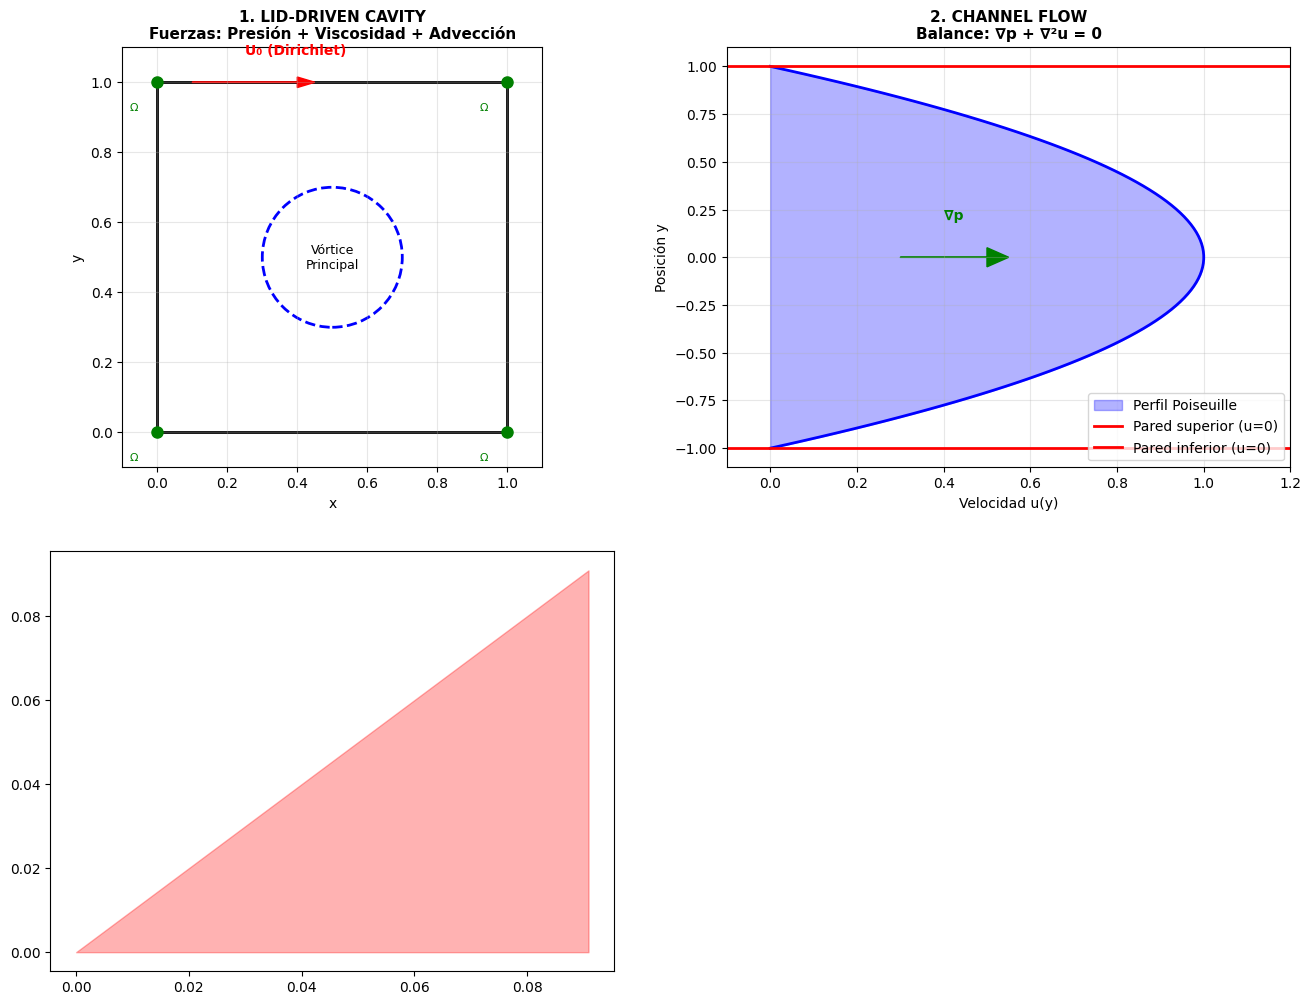

In [ ]:
# Crear visualización esquemática de interacción de fuerzas
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, figure=fig)

# 1. Cavidad: Diagrama de fuerzas
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_aspect('equal')

# Dibujar cavidad
from matplotlib.patches import Rectangle, FancyArrowPatch
cavity_rect = Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linewidth=2)
ax1.add_patch(cavity_rect)

# Tapa móvil con flecha
ax1.arrow(0.1, 1.0, 0.3, 0, head_width=0.03, head_length=0.05, fc='red', ec='red')
ax1.text(0.25, 1.08, 'U₀ (Dirichlet)', fontsize=10, color='red', weight='bold')

# Vórtice principal
circle = plt.Circle((0.5, 0.5), 0.2, fill=False, edgecolor='blue', linewidth=2, linestyle='--')
ax1.add_patch(circle)
ax1.text(0.5, 0.5, 'Vórtice\nPrincipal', fontsize=9, ha='center', va='center')

# Esquinas (puntos críticos)
for corner in [(0, 0), (1, 0), (0, 1), (1, 1)]:
    ax1.plot(corner[0], corner[1], 'go', markersize=8)
    ax1.text(corner[0]-0.08, corner[1]-0.08, 'Ω', fontsize=8, color='green')

ax1.set_title('1. LID-DRIVEN CAVITY\nFuerzas: Presión + Viscosidad + Advección', fontsize=11, weight='bold')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True, alpha=0.3)

# 2. Canal: Desarrollo del perfil
ax2 = fig.add_subplot(gs[0, 1])
y = np.linspace(-1, 1, 100)
u_poiseuille = channel.poiseuille_profile(y)

ax2.fill_betweenx(y, 0, u_poiseuille, alpha=0.3, color='blue', label='Perfil Poiseuille')
ax2.plot(u_poiseuille, y, 'b-', linewidth=2)
ax2.axhline(y=1, color='red', linestyle='-', linewidth=2, label='Pared superior (u=0)')
ax2.axhline(y=-1, color='red', linestyle='-', linewidth=2, label='Pared inferior (u=0)')
ax2.arrow(0.3, 0, 0.2, 0, head_width=0.1, head_length=0.05, fc='green', ec='green')
ax2.text(0.4, 0.2, '∇p', fontsize=10, color='green', weight='bold')
ax2.set_title('2. CHANNEL FLOW\nBalance: ∇p + ∇²u = 0', fontsize=11, weight='bold')
ax2.set_xlabel('Velocidad u(y)')
ax2.set_ylabel('Posición y')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.1, 1.2)

# 3. Capa límite: Estructura de scales
ax3 = fig.add_subplot(gs[1, 0])

y_scales = np.linspace(0, 1, 100)
# Subcapa viscosa (y+ < 5)
subcapa = y_scales[y_scales < 0.1]
u_subcapa = subcapa  # Perfil lineal

# Buffer layer (5 < y+ < 30)
buffer_mask = (y_scales >= 0.1) & (y_scales < 0.3)
buffer = y_scales[buffer_mask]
u_buffer = np.log(buffer + 1) / 2.5 + 5

# Núcleo turbulento
nucleo_mask = y_scales >= 0.3
nucleo = y_scales[nucleo_mask]
u_nucleo = np.log(nucleo + 1) / 2.5 + 8

ax3.fill_between(u_subcapa, subcapa, alpha=0.3, color='red', label='Subcapa viscosa')
ax3.fill_between(buffer, 0, np.ones_like(buffer)*0.3, alpha=0.3, color='orange', label='Buffer layer')
ax3.fill_between(nucleo, 0, np.ones_like(nucleo), alpha=0.3, color='blue', label='Núcleo turbulento')

ax3.plot(u_subcapa, subcapa, 'r-', linewidth=2, label='u+ = y+')
ax3.axhline(y=0, color='black', linewidth=3, label='Pared (u=0)')
ax3.set_title('3. TURBULENT BOUNDARY LAYER\nEstructura de escalas viscosas', fontsize=11, weight='bold')
ax3.set_xlabel('Velocidad u+')
ax3.set_ylabel('Posición y+')
ax3.legend(loc='lower right', fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Tabla de escalas características
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Tabla de escalas
escalas_text = f"""
ESCALAS CARACTERÍSTICAS VS REYNOLDS
{'─'*50}

Cavidad (Re = {cavity.Re}):
  • Espesor capa límite: δ ~ Re^(-0.25) = {cavity.Re**(-0.25):.4f}
  • Vórtices secundarios en esquinas
  • Vorticidad: ω ~ Re^0.75

Canal (Re = {channel.Re}):
  • Entrada desarrollo: L_e ~ 0.05*Re = {0.05*channel.Re:.0f}
  • Longitud entrada/altura: {(0.05*channel.Re)/4:.0f}
  • Viscosidad disipación: ε ~ ν*U²/δ²

Capa Límite Turbulenta (Re = {bl.Re}):
  • Escala viscosa: y+ = y*u_τ/ν ~ √Re
  • Escala Kolmogorov: η ~ Re^(-3/4) = {bl.Re**(-0.75):.6f}
  • Número de estructuras: N_eddy ~ Re^1.25
  • Esfuerzo pared: τ_wall ~ Re^(-1/4)
"""

ax4.text(0.05, 0.95, escalas_text, transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('INTERACCIÓN DE FUERZAS FÍSICAS EN CONDICIONES DE FRONTERA\nNavier-Stokes 3D', 
             fontsize=14, weight='bold', y=0.98)
plt.tight_layout()
plt.savefig('../boundary_conditions_interactions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualización guardada: boundary_conditions_interactions.png")

## 9️⃣ Conclusiones y Próximas Direcciones

### Hallazgos Clave

1. **Cavidad con Tapa Móvil**
   - Complejidad de interacción: Alta (3 tipos de fuerzas)
   - Puntos críticos: 4 esquinas + centro vórtice
   - Escalas: Fuertemente dependientes de Reynolds
   - Aplicación: Validación de códigos numéricos

2. **Flujo en Canal**
   - Balance de fuerzas: Simple (∇p ↔ viscosidad)
   - Punto crítico: Entrada (desarrollo del perfil)
   - Escalas: Predecibles analíticamente
   - Aplicación: Turbulencia isótropa

3. **Capa Límite Turbulenta**
   - Complejidad: Máxima (turbulencia + viscosidad + presión)
   - Puntos críticos: Pared (subcapa viscosa) + núcleo turbulento
   - Escalas: Rango amplio (Re^(-3/4) a Re^0.75)
   - Aplicación: Fenómenos reales (aerodinámico, hidrodinámico)

### Próximas Investigaciones

- **Newton-Bernstein Adaptativo**: Refinar localmente en puntos críticos
- **Análisis de Sensibilidad**: Cómo pequeños cambios en BC afectan soluciones
- **Bifurcaciones**: Transiciones de estabilidad con parámetros (Re, etc.)
- **Optimización**: Encontrar BC óptimas para control de flujo
- **Machine Learning**: Predicción de flujo con BC dados